## Reinforcement Learning methods for the multi-armed bandit problem

Click here for other works of the author on RPubs("http://rpubs.com/prorichter")

The multi-armed bandit problem is a hypothetical problem of a person choosing which slot machines to play in a casino. Each machine yields a reward generated through some unknown process when played. On each turn, the person must choose a machine to play based on information gathered previously. The objective of the problem is to maximize the sum of rewards earned through a sequence of decision.

The problem is interesting because it involves a fundamental trade-off between the gain from exploiting choices that had worked well previously vs exploring choices that might potentially be optimal, but appeared to be inferior because of randomness. This “exploration” / “exploitation” trade-off can be observed in many real world problems such as choosing which products to buy, advertisement selection, medical treatment selection or financial portfolio design.

Below I will demonstrate two algorithms, upper confidence limits (UCB) and Thompson sampling (or probability matching strategy, a more general term), that tries to solve the multi-armed bandit problem. I will compare their performance and strategy in three scenarios: standard rewards, standard but more volatile rewards, somewhat chaotic rewards.

#### -----------------------Case 1-----------------------
1. Load Packages
2. Distribution of bandits / actions having normally distributed rewards with small variance
3. Upper confidence bound algorithm
4. Conduct UCB algorithm on our hypothesized bandits with normal distributions
5. Thompson sampling algorithm
6. Conduct Thompson sampling using Normal-Gamma prior and Normal likelihood to estimate posterior distribution
#### -----------------------Case 2-----------------------
7. Distribution of bandits / actions having normally distributed rewards with large variance
8. Conduct UCB on rewards with higher variance
9. Conduct Thompson sampling on rewards with higher variance
#### -----------------------Case 3-----------------------
10. Distribution of bandits / actions with rewards of different distributions
11. Conduct UCB on rewards with different distributions
12. Conduct Thompson sampling on rewards with different distributions
#### -----------------------Conclusion-----------------------
13. Appendix
#### -----------------------What's Next-----------------------
14. MCMC algorithm using OpenBUGS
15. Thompson sampling algorithm using MCMC
16. Conduct Thompson sampling using MCMC to estimate posterior distributions
17. Reinforcement Learning Case Example in PT. Solusi 247

### 1. Load Packages

In [1]:
library(ggplot2)
library(reshape2)
library(R2OpenBUGS)

#install.packages("R2OpenBUGS")

### 2. Distribution of bandits / actions having normally distributed rewards with small variance

This data represents an standard, ideal situation: normally distributed rewards, well seperated from each other.

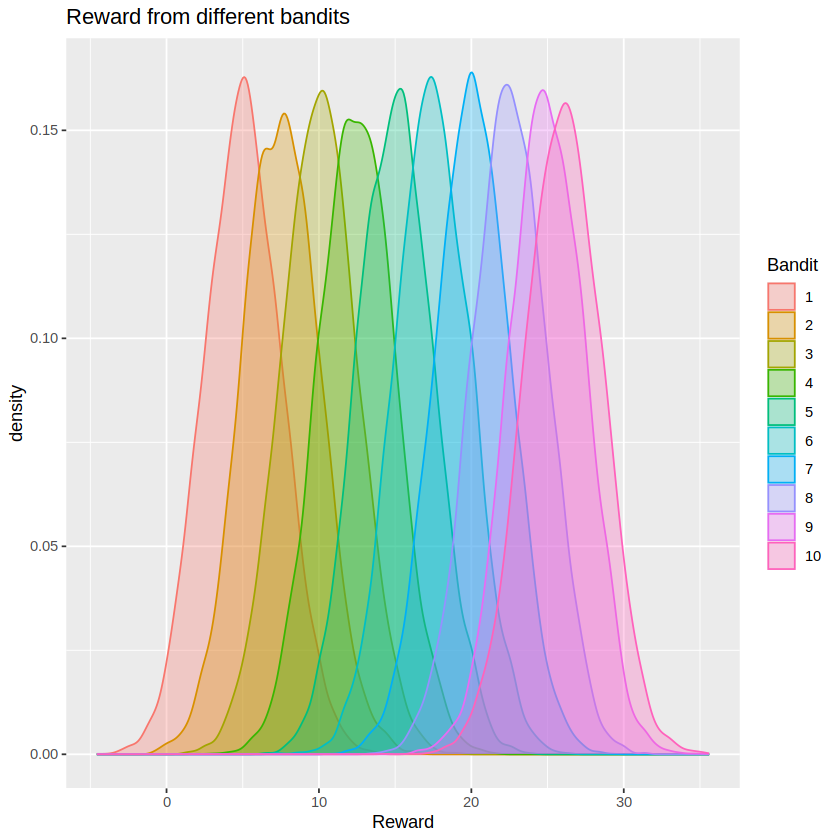

In [2]:
mean_reward = c(5, 7.5, 10, 12.5, 15, 17.5, 20, 22.5, 25, 26)
reward_dist = c(function(n) rnorm(n = n, mean = mean_reward[1], sd = 2.5),
                function(n) rnorm(n = n, mean = mean_reward[2], sd = 2.5),
                function(n) rnorm(n = n, mean = mean_reward[3], sd = 2.5),
                function(n) rnorm(n = n, mean = mean_reward[4], sd = 2.5),
                function(n) rnorm(n = n, mean = mean_reward[5], sd = 2.5),
                function(n) rnorm(n = n, mean = mean_reward[6], sd = 2.5),
                function(n) rnorm(n = n, mean = mean_reward[7], sd = 2.5),
                function(n) rnorm(n = n, mean = mean_reward[8], sd = 2.5),
                function(n) rnorm(n = n, mean = mean_reward[9], sd = 2.5),
                function(n) rnorm(n = n, mean = mean_reward[10], sd = 2.5))
                  
#prepare simulation data
dataset = matrix(nrow = 10000, ncol = 10)
for(i in 1:10){
    dataset[, i] = reward_dist[[i]](n = 10000)
}
colnames(dataset) <- 1:10
dataset_p = melt(dataset)[, 2:3]
colnames(dataset_p) <- c("Bandit", "Reward")
dataset_p$Bandit = as.factor(dataset_p$Bandit)

#plot the distributions of rewards from bandits
ggplot(dataset_p, aes(x = Reward, col = Bandit, fill = Bandit)) +
    geom_density(alpha = 0.3) +
    labs(title = "Reward from different bandits")

In [5]:
head(dataset,5)

1,2,3,4,5,6,7,8,9,10
6.056668,8.891334,12.544885,11.208738,14.16207,16.10701,17.61817,21.49834,24.18728,26.16387
9.741910,7.819521,10.211145,6.873931,11.70938,13.86496,19.88889,19.84996,23.72281,27.83511
2.991689,10.934971,8.823556,11.359071,16.79980,16.12389,14.01614,23.92043,22.72120,25.73781
3.975757,3.377231,8.053306,12.138571,13.07181,19.20633,21.11800,28.64272,26.65374,29.15781
3.786238,4.942727,9.401532,13.406401,16.42400,18.59865,18.84577,21.97268,28.65106,24.22295


Firstly, we create 10 columns of rewards with normally distributed value, and well separated from each other. Each columns represent different machine in casino.

In [18]:
print(integer(0))

integer(0)


### 3. Upper confidence bound algorithm

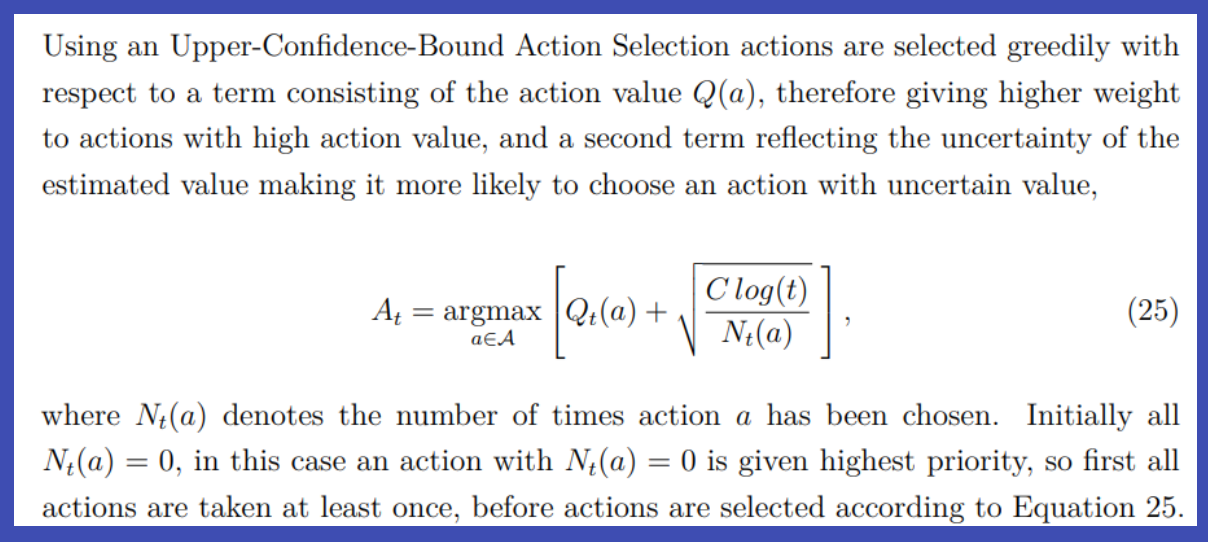

In [33]:
UCB <- function(N = 1000, reward_data){
    d = ncol(reward_data)
    bandit_selected = integer(0) # bandit selected initiation
    numbers_of_selections = integer(d) # 0.0.0.0.0.0.0.0.0.0. -> initiation numbers of selection for each columns
    sums_of_rewards = integer(d) # 0.0.0.0.0.0.0.0.0.0. -> initiation sum of rewards for each columns
    total_reward = 0 # total reward initialization
    for (n in 1:N) { # for each n in 1 up to N (specified number of rows)
        max_upper_bound = 0 # Set upper bound
            for (i in 1:d) { # for each i in 1 up to d (specified number of columns)
                if (numbers_of_selections[i] > 0){ # if number of selection more than 0
                    average_reward = sums_of_rewards[i] / numbers_of_selections[i] # Obtain average reward
                    delta_i = sqrt(2 * log(1 + n * log(n)^2) / numbers_of_selections[i])
                    upper_bound = average_reward + delta_i # calculate upper bound 
                } else { # If number of selection equal or less than 0
                    upper_bound = 1e400 # set upper bound as 1*10^400
                }
                if (upper_bound > max_upper_bound){ # if upper_bound more than max_upper_bound,
                    max_upper_bound = upper_bound # update the max_upper_bound
                    bandit = i # update the bandit as current column index
                }
            }
    bandit_selected = append(bandit_selected, bandit) # append column to bandit_selected
    numbers_of_selections[bandit] = numbers_of_selections[bandit] + 1 # numbers_of_selections + 1 at current column
    reward = reward_data[n, bandit] # take reward for specified row and column
    sums_of_rewards[bandit] = sums_of_rewards[bandit] + reward # sum of rewards at current column
    total_reward = total_reward + reward # calculate total reward
    }
    return(list(total_reward = total_reward, 
                bandit_selected = bandit_selected, 
                numbers_of_selections = numbers_of_selections, 
                sums_of_rewards = sums_of_rewards))
}

### 4. Conduct UCB algorithm on our hypothesized bandits with normal distributions

In [35]:
UCB(N = 1000, reward_data = dataset)

$total_reward
       1 
25875.06 

$bandit_selected
   [1]  1  2  3  4  5  6  7  8  9 10 10 10 10 10 10 10  9  9  9  9  9  9  9  9
  [25]  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9 10  9  9 10 10
  [49] 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
  [73] 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
  [97] 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 [121] 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 [145] 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 [169] 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 [193] 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 [217] 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 [241] 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 [265] 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 [289] 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 [313] 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 [337] 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 [361] 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 [385] 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 [409] 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 [433] 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 [457] 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 [481] 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 [505] 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 [529] 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 [553] 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 [577] 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 [601] 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 [625] 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 [649] 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 [673] 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 [697] 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 [721] 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 [745] 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 [769] 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 [793] 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 [817] 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 [841] 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 [865] 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 [889] 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 [913] 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 [937] 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 [961] 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 [985] 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10

$numbers_of_selections
 [1]   1   1   1   1   1   1   1   1  30 962

$sums_of_rewards
 [1]     6.056668     7.819521     8.823556    12.138571    16.423999
 [6]    13.773506    19.540290    20.170536   746.655176 25023.661937

### 5. Thompson sampling algorithm

Thompson sampling, named after William R. Thompson, is a heuristic for choosing actions that addresses the exploration-exploitation dilemma in the multi-armed bandit problem. It consists of choosing the action that maximizes the expected reward with respect to a randomly drawn belief. Thompson Sampling involves using probability distributions to model the uncertainty associated with each action. 

The basic idea of Thompson sampling is that in each round, we take our existing knowledge of the machines, which is in the form of a posterior belief about the unknown parameters, and we "sample" the parameters from this posterior distribution. This sampled parameter yields a set of expected rewards for each machine, and now we bet on the one with the highest expected return, under that sampled parameter.

Source: 
* https://www.wikiwand.com/en/Thompson_sampling
* http://www.learn-stat.com/parallel-distributed-thompson-sampling/
* https://stats.stackexchange.com/questions/187059/what-is-thompson-sampling-in-laymans-terms

In [38]:
# Create function to generate dataframe with gamma distribution
rnormgamma <- function(n, mu, lambda, alpha, beta){
    if(length(n) > 1) 
    n <- length(n)
    tau <- rgamma(n, alpha, beta)
    x <- rnorm(n, mu, 1 / (lambda * tau))
    data.frame(tau = tau, x = x)
}

# Create Thompson sampling algorithm
T.samp <- function(N = 500, reward_data, mu0 = 0, v = 1, alpha = 2, beta = 6){
    d = ncol(reward_data)
    bandit_selected = integer(0)
    numbers_of_selections = integer(d)
    sums_of_rewards = integer(d)
    total_reward = 0
    reward_history = vector("list", d)
    for (n in 1:N){
        max_random = -1e400
        for (i in 1:d){
            if(numbers_of_selections[i] >= 1){
                rand = rnormgamma(1, 
                              (v * mu0 + numbers_of_selections[i] * mean(reward_history[[i]])) / (v + numbers_of_selections[i]), 
                              v + numbers_of_selections[i], 
                              alpha + numbers_of_selections[i] / 2, 
                              beta + (sum(reward_history[[i]] - mean(reward_history[[i]])) ^ 2) / 2 + ((numbers_of_selections[i] * v) / (v + numbers_of_selections[i])) * (mean(reward_history[[i]]) - mu0) ^ 2 / 2)$x
            }else {
                rand = rnormgamma(1, mu0, v, alpha, beta)$x
            }
            if(rand > max_random){
                max_random = rand
                bandit = i
            }
        }
        bandit_selected = append(bandit_selected, bandit)
        numbers_of_selections[bandit] = numbers_of_selections[bandit] + 1
        reward = reward_data[n, bandit]
        sums_of_rewards[bandit] = sums_of_rewards[bandit] + reward
        total_reward = total_reward + reward
        reward_history[[bandit]] = append(reward_history[[bandit]], reward)
    }
     return(list(total_reward = total_reward, bandit_selected = bandit_selected, numbers_of_selections = numbers_of_selections, sums_of_rewards = sums_of_rewards))
}

### 6. Conduct Thompson sampling using Normal-Gamma prior and Normal likelihood to estimate posterior distributions

In [39]:
T.samp(N = 1000, reward_data = dataset, mu0 = 40)

$total_reward
       6 
24459.87 

$bandit_selected
   [1]  6  5  7  5  7  6  7  8  2  6  8  5  2  8  3  3  2  6  3  4  3 10  1 10
  [25]  1  4  9  7  4  4  2 10  6  1  8  9  5  6  1  5  7  2 10  4  3  2  4  9
  [49] 10  9  3  3  2  3 10 10  9  1  9  2 10  6  6 10  2 10  2  5  9  7  7  9
  [73]  8  9  5 10  1 10  8 10  9 10  9  6  2  7  5  1  9  3  1  3  7 10  6  4
  [97] 10 10  8  8  5 10 10  8 10  4 10 10  9 10  7 10  8  4 10  9 10 10  9  1
 [121] 10  9  6  1  5 10  9  8  9  9 10  7 10 10 10 10 10 10 10 10  2  2 10  1
 [145] 10  9  8  4 10 10 10  9 10  1 10 10 10 10 10 10  4 10  6 10 10 10 10 10
 [169] 10 10 10 10  5 10 10 10 10 10 10 10 10 10  9 10 10 10  9 10 10 10 10 10
 [193] 10  3 10 10 10  1 10  8  9 10  9 10 10 10 10  5 10  9 10 10 10  7 10 10
 [217] 10 10 10 10  9 10 10 10 10 10 10 10 10 10  8 10 10 10 10 10 10 10 10  9
 [241]  9 10 10 10 10 10 10 10 10  9  9  9 10  8  8 10  9 10  9 10 10 10 10 10
 [265] 10  9 10  4 10 10 10 10 10 10 10 10 10  8 10 10 10 10 10 10 10 10 10  9
 [289] 10 10 10 10 10 10  9 10  9 10 10  9 10  9 10  3 10  7  9  9  9 10 10 10
 [313]  9 10  9  9  9 10 10 10  9  9 10 10  9  9 10 10 10 10 10 10 10  9  9 10
 [337]  9  9  9  9  3  9  9  9  5  9 10 10  9 10 10 10 10 10 10 10 10 10 10 10
 [361] 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 [385] 10  8 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10  9 10 10
 [409] 10 10 10 10 10 10 10 10 10  6 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 [433] 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 [457] 10  9 10 10 10 10 10 10 10 10 10 10 10  9 10 10 10 10 10 10 10 10 10 10
 [481] 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10  8 10 10 10 10
 [505]  9  9  9 10  4 10 10 10  9 10 10 10  7 10 10 10 10 10 10 10 10 10 10 10
 [529] 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10  9 10 10 10 10 10 10 10 10
 [553] 10 10 10 10 10 10 10  7 10 10 10 10 10 10 10 10 10  6 10 10 10 10 10 10
 [577] 10 10 10 10 10 10 10 10 10  9 10 10 10 10 10 10 10 10 10 10 10  8 10 10
 [601] 10 10 10 10 10 10 10  4 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 [625] 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10  4 10 10 10 10
 [649] 10 10 10 10 10 10 10 10 10 10 10 10 10 10  9 10 10 10 10 10 10 10 10 10
 [673] 10 10 10 10 10 10 10  5 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 [697] 10 10 10 10 10 10 10 10 10 10 10  3  4 10 10 10 10 10 10 10 10 10 10 10
 [721] 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 [745] 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 [769] 10 10 10 10 10 10 10 10 10 10 10 10 10  2 10 10 10 10 10 10 10 10 10 10
 [793] 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10  6 10 10 10 10 10 10 10 10
 [817] 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 [841] 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10  7 10 10 10 10 10 10
 [865] 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 [889] 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 [913] 10 10 10 10 10 10 10 10 10 10 10 10  6 10 10 10 10 10 10 10 10 10 10 10
 [937] 10 10 10 10 10 10 10 10 10 10 10 10 10  1 10 10 10 10 10  1 10 10 10 10
 [961] 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 [985] 10 10  4 10 10 10 10 10 10 10 10 10 10 10 10 10

$numbers_of_selections
 [1]  15  14  14  17  14  16  16  20  72 802

$sums_of_rewards
 [1]    82.68475   110.53464   129.76578   227.47996   206.72568   270.12864
 [7]   315.86173   456.10495  1845.67422 20814.91033

We can see that the UCB algorithm quickly found out that the 10th
 bandit yields most reward. On the other hand, Thompson sampling tried the worse bandits a lot more times before finding the best one.

### 7. Distribution of bandits / actions having normally distributed rewards with large variance

This data represents an ideal but more unstable situation: normally distributed rewards with much larger variance, thus not well seperated from each other.

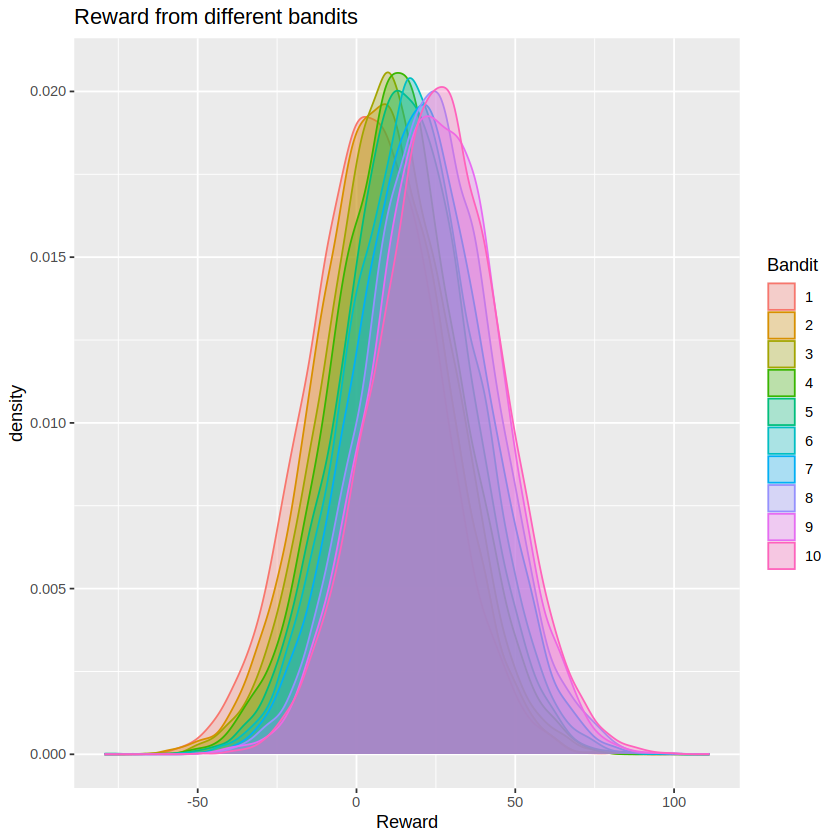

In [40]:
mean_reward = c(5, 7.5, 10, 12.5, 15, 17.5, 20, 22.5, 25, 26)
reward_dist = c(function(n) rnorm(n = n, mean = mean_reward[1], sd = 20),
                function(n) rnorm(n = n, mean = mean_reward[2], sd = 20),
                function(n) rnorm(n = n, mean = mean_reward[3], sd = 20),
                function(n) rnorm(n = n, mean = mean_reward[4], sd = 20),
                function(n) rnorm(n = n, mean = mean_reward[5], sd = 20),
                function(n) rnorm(n = n, mean = mean_reward[6], sd = 20),
                function(n) rnorm(n = n, mean = mean_reward[7], sd = 20),
                function(n) rnorm(n = n, mean = mean_reward[8], sd = 20),
                function(n) rnorm(n = n, mean = mean_reward[9], sd = 20),
                function(n) rnorm(n = n, mean = mean_reward[10], sd = 20))
                  
#prepare simulation data
dataset = matrix(nrow = 10000, ncol = 10)
for(i in 1:10){
    dataset[, i] = reward_dist[[i]](n = 10000)
}
colnames(dataset) <- 1:10
dataset_p = melt(dataset)[, 2:3]
colnames(dataset_p) <- c("Bandit", "Reward")
dataset_p$Bandit = as.factor(dataset_p$Bandit)

#plot the distributions of rewards from bandits
ggplot(dataset_p, aes(x = Reward, col = Bandit, fill = Bandit)) +
    geom_density(alpha = 0.3) +
    labs(title = "Reward from different bandits")

### 8. Conduct UCB on rewards with higher variance

In [41]:
UCB(N = 1000, reward_data = dataset)

$total_reward
       1 
24378.75 

$bandit_selected
   [1]  1  2  3  4  5  6  7  8  9 10  5  2  9  9  9  9  9  9  9  9  9  9  9  9
  [25]  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9
  [49]  9  9  9  2  9  8  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9
  [73]  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9
  [97]  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9
 [121]  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9
 [145]  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9
 [169]  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9
 [193]  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9
 [217]  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9
 [241]  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9
 [265]  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9
 [289]  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9
 [313]  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9
 [337]  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9
 [361]  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9
 [385]  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9
 [409]  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9
 [433]  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9
 [457]  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9
 [481]  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9
 [505]  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9
 [529]  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9
 [553]  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9
 [577]  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9
 [601]  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9
 [625]  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9
 [649]  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9
 [673]  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9
 [697]  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9
 [721]  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9
 [745]  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9
 [769]  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9
 [793]  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9
 [817]  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9
 [841]  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9
 [865]  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9
 [889]  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9
 [913]  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9
 [937]  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9
 [961]  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9
 [985]  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9

$numbers_of_selections
 [1]   1   3   1   1   2   1   1   2 987   1

$sums_of_rewards
 [1]    -9.767119    48.317565     6.677694    -4.776097    24.537537
 [6]    17.735235    19.176389    34.648325 24246.051407    -3.854976

### 9. Conduct Thompson sampling on rewards with higher variance

In [42]:
T.samp(N = 1000, reward_data = dataset, mu0 = 40)

$total_reward
      10 
21626.33 

$bandit_selected
   [1] 10  2  8 10 10 10  8  8  3  6  8  3  5 10  9  5  3  3  5  9  8  7  7  4
  [25]  2  6  6  4  9  4  4  1  4  7  1  4  9  8  1  2  5  5  7  9  3  6 10  2
  [49]  6  2  1  9  1  8  7  7  7  5  2  1  8  4  4  6  4  1  9  5  8  8  8  8
  [73]  3  8  8  8  8  8  6  8  8  8  8  7  8  7  7  2  7  7  9  9  9  9  9  5
  [97]  9  9  7  9  1  7  6  6  4  9  2  5  6  9  9  6  9  9  3  6  6  9  6  1
 [121]  3  8 10  9  9  8  3  2  8  5  7  6  6  9  9  9  8  8  8  3  8 10  8  8
 [145]  9  3  7  2  7  7  7  7  7 10  8  8  6  9  7 10  7  5  6  8 10  8  8  8
 [169]  5  8  8  1  8  8  8  8  8 10  5  8  5  5  1  5  8  5  3 10  8  8  8 10
 [193]  8  8  8  8  8  5  8  4  5  1  8  6  8  2  5  8  8  8  5  5  8  8  8  8
 [217]  8  8  8  8  4  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  4 10  8
 [241]  8  8  8  8  8  8  8  8  8  8  8  8 10  8  8  8  8  8  8  8  8  8  8  8
 [265]  8  8  1  8  8  8  8  8  2  8  8  8  8  8  5  5  8  2  8  8  8  8  5  8
 [289]  8  8  8  8  8  8  8  3  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
 [313]  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
 [337]  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
 [361]  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
 [385]  8  8  8  8  8  8  8  8  8  8  8  8  8  8  4  8  8  8  8  8  8  8  8  8
 [409]  8  8  8  4  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
 [433]  8  2  8  8  8  8  8  8  8  8  8  8  8  8  8  7  8  8  8  7  7  7  8  8
 [457]  7  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
 [481]  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  6  8  8  7  8  8  8  8  8
 [505]  8  8  8  8 10  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
 [529]  8  8  8  8  8  8  8  8  8  3  8  8  8  8  8  8  8  8  8  8  8  8  8  8
 [553]  8  8  8  8  8  1  8  8  8  8  8  8  8  7 10  8  8  6  8  8  8  8  8  8
 [577]  8  8  8  8  1  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
 [601]  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
 [625]  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
 [649]  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
 [673]  7  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  7  8  8
 [697]  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
 [721]  8  9  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  9  8  8  8  8  8
 [745]  8  3  8  8  8  8  8  8  8  8  9  8  8  8  8  8  7  7  8  8  7  8  8  8
 [769]  8  8  8  1  8  8  8  8  8  8  8  8  4  8  8  8  8  8  8  8  8  8  8  8
 [793]  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
 [817]  8  8  8  8  8  8  8  8  8  9  8  1  8  8  8  8  8  8  8  8  8  8  8  8
 [841]  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
 [865]  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
 [889]  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
 [913]  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
 [937]  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
 [961]  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
 [985]  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8

$numbers_of_selections
 [1]  17  14  15  16  25  21  35 807  32  18

$sums_of_rewards
 [1]   159.45070    61.77177   117.49496   205.69491   503.38849   390.49231
 [7]   732.04053 18469.42638   679.68227   306.88466

When the fluctuation of rewards are greater, the UCB algorithm is more susceptible to being “stuck” at a suboptimal choice and never finds the optimal bandit. Thompson sampling is generally more robust and would be able to find the optimal bandit in all kinds of situations.

### 10. Distribution of bandits / actions with rewards of different distributions

This data represents an more chaotic (possibly more realistic) situation: rewards with different distribution and different variance.

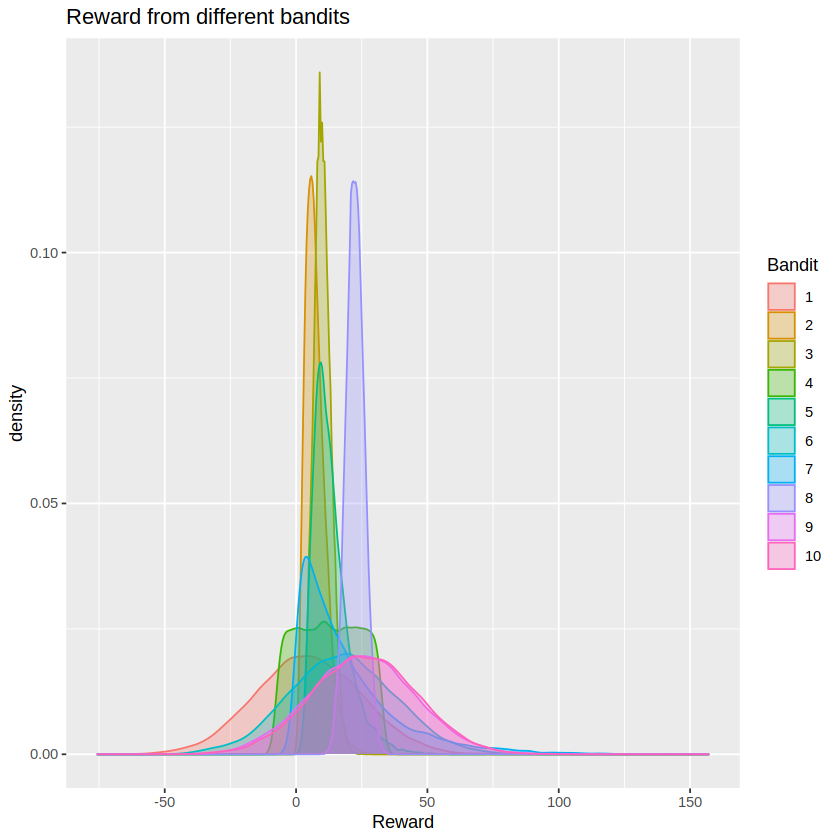

In [43]:
mean_reward = c(5, 7.5, 10, 12.5, 15, 17.5, 20, 22.5, 25, 26)
reward_dist = c(function(n) rnorm(n = n, mean = mean_reward[1], sd = 20),
                function(n) rgamma(n = n, shape = mean_reward[2] / 2, rate = 0.5),
                function(n) rpois(n = n, lambda = mean_reward[3]),
                function(n) runif(n = n, min = mean_reward[4] - 20, max = mean_reward[4] + 20),
                function(n) rlnorm(n = n, meanlog = log(mean_reward[5]) - 0.25, sdlog = 0.5),
                function(n) rnorm(n = n, mean = mean_reward[6], sd = 20),
                function(n) rexp(n = n, rate = 1 / mean_reward[7]),
                function(n) rbinom(n = n, size = mean_reward[8] / 0.5, prob = 0.5),
                function(n) rnorm(n = n, mean = mean_reward[9], sd = 20),
                function(n) rnorm(n = n, mean = mean_reward[10], sd = 20))
                  
#prepare simulation data
dataset = matrix(nrow = 10000, ncol = 10)
for(i in 1:10){
    dataset[, i] = reward_dist[[i]](n = 10000)
}
colnames(dataset) <- 1:10
dataset_p = melt(dataset)[, 2:3]
colnames(dataset_p) <- c("Bandit", "Reward")
dataset_p$Bandit = as.factor(dataset_p$Bandit)

#plot the distributions of rewards from bandits
ggplot(dataset_p, aes(x = Reward, col = Bandit, fill = Bandit)) +
    geom_density(alpha = 0.3) +
    labs(title = "Reward from different bandits")

### 11. Conduct UCB on rewards with different distributions

In [44]:
UCB(N = 1000, reward_data = dataset)

$total_reward
       1 
26171.58 

$bandit_selected
   [1]  1  2  3  4  5  6  7  8  9 10  6  9 10 10 10  9 10 10 10 10 10 10  8  9
  [25] 10 10 10 10 10  8 10  9 10  8  6 10 10 10 10 10 10 10 10 10 10 10 10 10
  [49] 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10  6  6  6  8 10
  [73] 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
  [97] 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 [121] 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 [145] 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 [169] 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 [193] 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 [217] 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 [241] 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 [265] 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 [289] 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 [313] 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 [337] 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 [361] 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 [385] 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 [409] 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 [433] 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 [457] 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 [481] 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 [505] 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 [529] 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 [553] 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 [577] 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 [601] 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 [625] 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 [649] 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 [673] 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 [697] 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 [721] 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 [745] 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 [769] 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 [793] 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 [817] 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 [841] 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 [865] 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 [889] 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 [913] 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 [937] 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 [961] 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 [985] 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10

$numbers_of_selections
 [1]   1   1   1   1   1   6   1   5   5 978

$sums_of_rewards
 [1]    16.253104     7.630748    10.000000    14.241143     9.786030
 [6]   123.737569     4.257145   111.000000    97.298421 25777.377166

### 12. Conduct Thompson sampling on rewards with different distributions

In [45]:
T.samp(N = 1000, reward_data = dataset, mu0 = 40)

$total_reward
       4 
25006.41 

$bandit_selected
   [1]  4  1  2  1  4  4  9  5  2  9  2  4  1  5  7 10  8 10  1  9 10  4  2  3
  [25] 10  6 10  3  6  6  6  3  6  7  7  7  4  2  3  7  8  7 10  9  4  8  9  5
  [49]  1  5  1 10  3  1  7 10  4  8  7  5  6  8  2  6  4  9 10  4  3  1  7  3
  [73]  9  7  5  8  3  7  2  7  5  5  8 10  6 10  5 10 10 10 10 10 10  7 10  9
  [97]  8 10  9 10 10 10  6 10 10  9  8  7 10 10 10  2  9  8  2 10 10 10 10 10
 [121]  6 10  5 10  3 10 10 10 10  6 10  1 10 10 10 10 10 10 10  5 10 10 10  8
 [145] 10  8 10 10 10 10 10 10  4 10 10  1 10 10 10 10  1 10 10 10  8  4 10 10
 [169]  3 10  2 10 10  8 10 10 10 10 10  8 10 10  9  2 10 10 10 10  9 10 10  2
 [193] 10  5  1 10 10  3 10  6 10 10 10 10 10 10 10  7 10 10 10 10 10 10 10 10
 [217] 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 [241] 10 10 10 10  5 10 10 10 10 10 10 10 10  8 10 10 10 10 10 10 10 10 10 10
 [265] 10  3 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 [289]  1 10 10 10 10 10 10 10 10 10 10  9 10 10 10 10 10  9 10 10 10 10 10 10
 [313] 10 10 10 10 10 10 10  2 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10  1
 [337] 10 10 10 10  3 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 [361] 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 [385] 10 10 10 10 10 10 10 10 10 10 10  6 10 10 10 10 10 10 10 10 10 10 10 10
 [409] 10 10 10 10 10 10  7 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 [433] 10 10 10 10 10  7 10 10 10 10 10  8 10 10 10 10 10 10 10 10 10  8 10 10
 [457] 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 [481] 10 10 10 10 10 10 10 10 10 10 10 10 10  5 10 10 10 10 10 10 10 10 10 10
 [505] 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 [529] 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 [553] 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10  4 10 10 10 10
 [577] 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 [601] 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 [625] 10 10  6 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 [649] 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 [673] 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 [697] 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 [721] 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 [745] 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 [769] 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 [793] 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 [817] 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 [841] 10 10 10 10 10 10 10 10 10 10 10  9 10 10 10 10 10 10 10 10 10  3 10 10
 [865] 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 [889] 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 [913] 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 [937] 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 [961] 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 [985] 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10

$numbers_of_selections
 [1]  14  13  14  13  14  14  17  18  16 867

$sums_of_rewards
 [1]    74.08919   116.82279   128.00000   135.92210   205.04815   179.46223
 [7]   368.10904   401.00000   340.96485 23056.99113

The performance of the two algorithm are similar to what we’ve observed in the previous condition.

A major reason why the Thompson sampling algorithm tries all bandits several times before choosing the one it considers best is because I chose a prior distribution with a relatively high mean. <u>With a prior having a larger mean, the algorithm favors “exploration” over “exploitation” at the beginning and only when it is very confident that it has found the best choice that it valued “exploitation” over “exploration”</u>. If we decrease the mean of prior, “exploitation” would have a higher value and the algorithm would stop exploring faster. <u>by chaning the prior distribution used, one can adjust the relative importance of “exploration” over “exploitation” to suit specific problems on hand</u>. This a another testament to how flexible the Thompson sampling algorithm is.

### 13. Appendix
From the demonstrations above, we have seen how Thompson sampling can be more robust than methods based on optimal, standard situations such as UCB. However, using the approach we’ve implemented, one must use conjugate priors of the likelihood in order to update posterior distributions in a straight forward way. What if approapriate conjugate priors do not exist or one wish to construct hierarchecal models which include other variables that might affect rewards gained? In such cases, <u>posterior distributions of the reward cannot be estimated by the usual way</u>. Luckily, researches have developed more flexible methods for estimating the posterior. In this appendix, I will show one of the most powerful and commonly used technique, Markoc chain Monte Carlo (MCMC).

Markoc chain Monte Carlo algorithms attempt to “sample” from posterior distribution by constructing a Markov chain. With sufficient samples and applying other control measures (ex. thinning & burn in), <u>these samples drawn from the Markov chain will approximate the posterior</u>. This type of algorithms are able to sample from joint distributions in all kinds of models with great flexibility and accuracy.

As good as it sounds, MCMC algorithms have a major drawback, which is its slow speed relative to other methods. This being said, the flexibility and robustness MCMC algorithms offer are still rarely matched by other algorithms. My personal advice would be to use other methods when the problem at hand is relatively standard and use MCMC when one wish to build sophisticated models that include other explanatory variables.

### 14. MCMC algorithm using OpenBUGS
We use the same model as we’ve introduced before: a normal-gamma prior with a normal likelihood.

MCMC can be conducted in many different ways. I will give example codes using OpenBUGS, a software designed to perform Gibbs sampling (one type of MCMC). The package R2OpenBUGS allows us to call OpenBUGS from R.

In [46]:
#load package R2OpenBUGS
library(R2OpenBUGS)

#self-defined function that returns samples from the posterior
MCMC <- function(reward, n.iter = 1000, n.chains = 1, n.burnin = 100, n.thin = 10, ...){
    n = length(reward)
    est_mu = mean(reward)
    if(n == 1){
        return(rnorm(n.iter - n.burnin, est_mu, 100))
    }
    my.data <- list("reward", "n", "est_mu")
    model = function(){
        for(i in 1:n){
            reward[i] ~ dnorm(mu, tau)
        }
        mu ~ dnorm(est_mu, 0.001)
        tau ~ dgamma(0.001, 0.001)
    }
    my.model.file <- "model_bandit.odc" 
    write.model(model, con = my.model.file)
    
    params <- c("mu")
    
    inits <- function(){
        list(mu = 5, tau = 1)
    }
    out <- bugs(data = my.data, inits = inits, parameters.to.save = params, model.file = my.model.file, codaPkg = T, n.iter = n.iter, n.chains = n.chains, n.burnin = n.burnin, n.thin = n.thin, save.history = F, ...)
    bugs_out <- read.bugs(out, quiet = T)
    return(bugs_out[[1]][, 2])
}

### 15. Thompson sampling algorithm using MCMC
Same function as T.samp function above but estimates posterior distribution of mean reward using MCMC.

In [47]:
T.samp.mcmc <- function(N = 500, reward_data, mcmc.iter = 1000, mcmc.burnin = 100, show.iter = FALSE, ...){
    d = ncol(reward_data)
    bandit_selected = integer(0)
    numbers_of_selections = integer(d)
    sums_of_rewards = integer(d)
    total_reward = 0
    posterior_dist = matrix(9999, nrow = mcmc.iter - mcmc.burnin, ncol = d, n.mcmc = )
    reward_history = vector("list", d)
    for (n in 1:N){
        max_random = 0
        for (i in 1:d){
            rand = sample(posterior_dist[, i], 1)
            if(rand > max_random){
                max_random = rand
                bandit = i
            }
        }
        bandit_selected = append(bandit_selected, bandit)
        numbers_of_selections[bandit] = numbers_of_selections[bandit] + 1
        reward = reward_data[n, bandit]
        sums_of_rewards[bandit] = sums_of_rewards[bandit] + reward
        total_reward = total_reward + reward
        reward_history[[bandit]] = append(reward_history[[bandit]], reward)
        posterior_dist[, bandit] = as.vector(MCMC(reward = reward_history[[bandit]], n.iter = mcmc.iter, n.burnin = mcmc.burnin, ...))
        
        if(show.iter == TRUE)
        cat()
    }
    return(list(total_reward = total_reward, bandit_selected = bandit_selected, numbers_of_selections = numbers_of_selections, sums_of_rewards = sums_of_rewards))
}

### 16. Conduct Thompson sampling using MCMC to estimate posterior distributions

In [48]:
T.samp.mcmc(N = 200, reward_data = dataset)

ERROR: Error in matrix(9999, nrow = mcmc.iter - mcmc.burnin, ncol = d, n.mcmc = ): unused argument (alist(n.mcmc = ))


P.S. Codes using MCMC are not runned due to its slow speed, you are welcome to try it yourself.

## 17. Reinforcement Learning Case Example in IT Consultant Company

IT Consultant Company relies on IT project as major income. Resource allocation is a key decision-making process in project management that assign resources to activities of a project and determines the timing of the allocation in a cost and time effective manner. To avoid project risk such as delay, overbudget, and additional penalty, Reinforcement Learning may able to seek the best resource allocation policy.

#### <b>Case Description</b>
<b>Agent</b> : Project manager or project management representative that having task to assign resource to the project \
<b>Action</b> : Assign additional resource or not assign additional resource \
<b>States</b> : Assume project has 5 activities to finish \
<b>Reward</b> : Time to finish the task \
<b>State Transition</b> : When start, it is certain that activitiy 1 can be completed. When transitioning from activities 1, it is likely continued to activities 2, but also possible to goes to activity 4. From activity 2, it is likely proceed to activity 4 but also possible to goes to activity 3. From activity 3, it is certain that next activity will be activity 2. From activity 4, it is more likely goes to activity 5 and less likely goes to activity 3. From activity 5, it unsure whether it can goes to activity 3 nor finishing the project. 

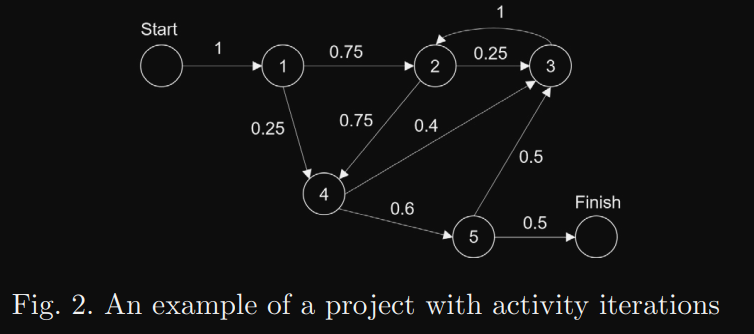


Source: https://www.sciencedirect.com/science/article/pii/S2405896320335588